# Tweeter sentiment Analysis

- The notebook is dedicated to the covid-19 tweet sentiment analysis.
- The data is taken from the source is - https://www.kaggle.com/heyytanay/covidindia-tweets-with-sentiment

- The data consists of tweets which contained the word "covidindia" from the beginning of the pandemic to 28-04-2021. Along with the tweet and it's metadata columns, there's also a sentiment column which has 2 possible values: NEGATIVE and POSITIVE.

## 1. Import Libraries

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 4.7 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3122730 sha256=09c18c2d91214590558d018903d2ba08fa9661fe231df75d57e0a423a6863b02
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import nltk
import string
import operator
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

nltk.download('stopwords')
nltk.download('vader_lexicon')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Embedding, SpatialDropout1D, LSTM, Activation, Bidirectional, Concatenate

## 2. Import Data

In [ ]:
df = pd.read_csv("tweets.csv") ## reading dataset
print("Shape of the original dataset is {}.".format(df.shape)) ## getting shape
df.head() ## getting the top 5 rows

Shape of the original dataset is (9655, 10).


created_at  ...  sentiment
0  2021-04-27 23:55:06 UTC  ...   NEGATIVE
1  2021-04-27 23:35:39 UTC  ...   NEGATIVE
2  2021-04-27 23:18:00 UTC  ...   NEGATIVE
3  2021-04-27 23:16:27 UTC  ...   NEGATIVE
4  2021-04-27 22:04:08 UTC  ...   NEGATIVE

[5 rows x 10 columns]

- The dataset consists of 10 columns. Each of them represents the details about the tweets such as user_id, username, language on which tweet has been posted etc.
- We are going to deal with only english language here.

### 2.1 Language distribution and selection

In [ ]:
## langauge distributions
df["language"].value_counts()

en     5825
hi     1265
ta     1116
und     333
bn      215
ml      168
mr      165
kn      164
te       89
gu       74
it       45
in       43
ur       33
or       28
es       21
pt       21
tl       12
et        8
pa        5
fr        4
ar        4
nl        3
de        3
ca        3
da        1
ja        1
cs        1
no        1
lt        1
ro        1
ne        1
lv        1
Name: language, dtype: int64

In [ ]:
## selecting only english language
df_m1 = df[df["language"] == "en"]

## shape after getting the only language
print("Shape after selecting only english langauge is {}.".format(df_m1.shape))

## percentage of english sentence present in the entire dataset
percent = round(((df_m1.shape[0]/df.shape[0]) * 100),3)
print("The percentage of english tweets present in the entire dataset is {}.".format(percent))

Shape after selecting only english langauge is (5825, 10).
The percentage of english tweets present in the entire dataset is 60.331.


In [ ]:
## though there are 10 columns along with the sentiments, the columns which we are going to analyse for the analysis 
## will be the tweets and the sentiments
## selecting the two columns
df_m2 = df_m1[["tweet", "sentiment"]]
print("Shape of the dataset is {}.".format(df_m2.shape))

Shape of the dataset is (5825, 2).


### 2.2 Hypothesis Testing

The tweets present in the dataset is done from various sources such as news channels, organizations, and normal users. After looking into tweets I can say most of the tweets are of negative sentiments. There are no difference in sentiments between any individual user or any news organization.

#### Assumption : There is no difference in negative sentiment scores, tweeted by news organization and individual users.

- alpha = 0.05 

In [ ]:
## selecting handfull of new organization to get tweets
news_agency_org = ['Hindustan Times', 'Business Insider India🇮🇳', 'moneycontrol', 'ET NOW', 'Milaap', 'IndiaToday', 'CARE International',
                   'The Pioneer', 'India Ahead News', 'Business Today', 'ETimes', 'FinancialXpress', 'Zee News English', 'Business Standard',
                   'CNBC-TV18', 'Oneindia News', 'Forbes India', 'SportsFlashes', 'OTV', 'India TV', 'Change.org Australia', 'Amnesty International',
                   'NDTV', 'The New Indian Express', 'GOODTIMES', 'The London Economic', 'TOI Mumbai', 'Advertising and Media Insider India',
                   'Times of Oman', 'Bangalore Mirror', 'ETHealthWorld', 'National Herald', 'The Telegraph', 'BritAsia TV', 'Dynamite News']

In [ ]:
## generating sentiment scores
vader = SentimentIntensityAnalyzer()
scores = df_m1['tweet'].apply(vader.polarity_scores).tolist()
df_m1['Score'] = scores

## getting individual scores
neg_list = []; neu_list = []; pos_list = []; compound_list = []
for i in df_m1['Score']:
    neg_list.append(i['neg'])
    neu_list.append(i['neu'])
    pos_list.append(i['pos'])
    compound_list.append(i['compound'])
df_m1['Neg'] = neg_list; df_m1['Neu'] = neu_list
df_m1['Pos'] = pos_list; df_m1['Compound'] = compound_list

In [ ]:
from scipy.stats import ttest_ind, norm

## to avoid the outliers issue in speed we are taking the speed_df as created above.
news_tweets = df_m1[df_m1['name'].isin(news_agency_org)]
indi_tweets = df_m1[~df_m1['name'].isin(news_agency_org)]

nt = news_tweets["Neg"].values
indt = indi_tweets["Neg"].values

ttest_ind(nt, indt, equal_var=False)

Ttest_indResult(statistic=-8.344472987045567, pvalue=1.1011160917559113e-16)

* As p-value is very very less than alpha, that means we reject the null hypothesis using t-test.
* That mean there is a significant difference in negative sentiment scores,tweeted by news organization and individual users.
* That means tweets done by news agency has less negativity in their tweets as compared to individual users.

### 2.3 Target Label Analysis

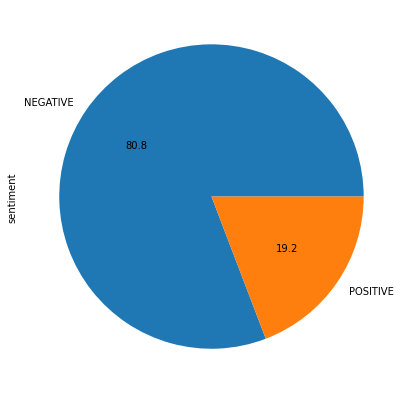

In [ ]:
## using pie chart to analyse the sentiment labels present in the dataset
plot = df_m2['sentiment'].value_counts(normalize=True).plot(kind='pie', autopct="%.1f", figsize=(7,7))

- The dataset is highly imbalance and only 19% of the data belongs to class positive and rest tweets are of negative sentiment.

### 2.4 null value analysis

In [ ]:
df_m2.isna().sum() ## checking for null values

tweet        0
sentiment    0
dtype: int64

- There are no null values present in the dataset.

### 2.5 duplicate data analysis

In [ ]:
df_m2[df_m2.duplicated()] ## checking for duplicate rows

tweet sentiment
262   National Conference president @OmarAbdullah ha...  NEGATIVE
368   Three more Haryana districts —Sonepat, Karnal ...  NEGATIVE
1268  Delhi's positivity rate has come down from mor...  NEGATIVE
1308  Covid: India sets another infection record as ...  NEGATIVE
1353  The US has decided to deploy “more supplies an...  NEGATIVE
1399  #CovidIndia | Amid an unprecedented surge in C...  NEGATIVE
1464  Amid a surge in Covid-19 cases across Jammu an...  NEGATIVE
1478  The Union government has scrapped basic custom...  NEGATIVE
1799  With ‘We Will Win’ Spirit, RSS Asks Its Swayam...  POSITIVE
3316  Details of #COVID19Vaccination registration fo...  NEGATIVE
3323  Pregnant &amp; Lactating women have not been p...  NEGATIVE
3359  As per @MoHFW_INDIA Precautions and Contraindi...  NEGATIVE
3361  Yes, you can get vaccinated with 2nd #COVIDVac...  NEGATIVE
3782  India is one of the largest importers of the w...  POSITIVE
3799  Even during COVID, India saw a rise in exports...  POSITIVE
3938  During COVID, India found permanent solutions ...  NEGATIVE
3939  During COVID, India found permanent solutions ...  NEGATIVE
3940  During COVID, India found permanent solutions ...  NEGATIVE
3943  During COVID, India found permanent solutions ...  NEGATIVE
3946  During COVID, India found permanent solutions ...  NEGATIVE
4040  In testing times of COVID, India has got recor...  POSITIVE
4127  #LifeSciences — Can a post-COVID India-Austral...  POSITIVE
4134  #LifeSciences — Can a post-COVID India-Austral...  POSITIVE
4456  During COVID, India has attracted foreign inve...  POSITIVE
4457  During COVID, India has attracted foreign inve...  POSITIVE
4737  Thousands of companies mull China exit after C...  NEGATIVE
4827  .@TCS' work-from-home (WFH) model has set new ...  NEGATIVE
4855  Thousands of companies mull China exit after C...  NEGATIVE
4930  Despite COVID, India-Nepal Border Row Takes a ...  NEGATIVE
4948  ☝️ This is a part of an ongoing series 'The Ec...  NEGATIVE
5258  Thousands of companies mull China exit after C...  NEGATIVE

- So there are duplicate tweets present in the dataset.

In [ ]:
## checking the shape and removing them
df_m3 = df_m2.drop_duplicates()
print("Shape after dropping the duplicate rows from the dataset is {}.".format(df_m3.shape))

Shape after dropping the duplicate rows from the dataset is (5794, 2).


## 3. Text Preprocessing

* Below are preprocessing techniques going to be used.

1. lowercasing the text
2. removal of retweets, url links, emoticons etc.
3. removal od stopwords
4. removal of punctuations
5. stemming

In [ ]:
def retweet_cleaning(text):
    """
    This function cleans all the re tweet tags, website tags along with al emojis, symbols and flags.
    """
    
    ## removal of retweets, hypertext, website tags
    text = re.sub(r'RT\s+@(.*?):', "", text)
    text = re.sub(r'RT\s+:', "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r"@\w+\s+", "", text)
    
    #emoji removal
    emoji = re.compile(
        u"(\ud83d[\ude00-\ude4f])|"  # emoticons
        u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
        u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
        u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
        u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
    
    ## lowercasing the text
    text = text.lower()
    
    ##removal of #tags
    text = re.sub(r"#\w+", "", text)
    
    ## removing punctuation
    text = re.sub(r'-', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    ## removal of stopwords
    text = remove_stopwords(text)
    
    ## removing numbers
    text = re.sub(" \d+", "", text)
    
    ## stemming of words
    ps = PorterStemmer()
    text = " ".join(ps.stem(val) for val in text.split())
    
    ## removing white spaces
    text = re.sub("\s\s\s+", "", text)
    text = text.strip()
    
    return text

In [ ]:
## preprocessing 
df_m3["preprocessed_tweet"] = df_m3["tweet"].apply(lambda x : retweet_cleaning(x))

In [ ]:
df_m3

tweet  ...                                 preprocessed_tweet
3     German Army working around the clock to help I...  ...  german armi work clock help india covid crisi ...
4     TBC, this is an old report. The point is that ...  ...  tbc old report point indian govern known use n...
5     "Most government-linked disinformation efforts...  ...  govern link disinform effort focus domest rese...
6     The news out of #India is devastating. #CovidI...  ...  news devast hurt countri bay area help gilroy ...
7     Second COVID wave has hampered India's economi...  ...  second covid wave hamper india econom recoveri...
...                                                 ...  ...                                                ...
9650  #COVID OR no Covid, India is not China or USA....  ...  covid india china usa burgeon imagin medic doc...
9651  Watch #CoronaVirusUpdate from Gandhi Hospital ...  ...                watch gandhi hospit peopl quarantin
9652  #CoronavirusUpdate || A 15 member team from #T...  ...        15 member team visit studi dealt posit case
9653  Ye gads ... Now NDTV’s  @harsha_ndtv reports a...  ...  ye gad ndtv report italian tourist test posit ...
9654  #JUSTIN || #Telangana man who returned from #D...  ...  man return test posit kept quarantin gandhi me...

[5794 rows x 3 columns]

- As we can above, after preprocess the text quality has been imporved.
- I have lower cased the data to avoid the case related word uniqueness, also applied potterstemmer to bring all the similar meaning words to it's root/stem words.

## 4. after preprocessing text analysis

In [ ]:
## getting total words present in each sentence so that we can remove where there are no more words left
df_m3["total_words"] = df_m3["preprocessed_tweet"].apply(lambda x : len(x.split()))
df_m3["total_words"].value_counts().sort_index() ## number of words present in the sentence in how many sentences

0       7
1      53
2      87
3     136
4     233
5     217
6     276
7     380
8     409
9     428
10    445
11    441
12    408
13    328
14    276
15    248
16    243
17    216
18    184
19    153
20    162
21    127
22     83
23     68
24     70
25     40
26     26
27     15
28     18
29     11
30      2
31      1
32      3
Name: total_words, dtype: int64

In [ ]:
df_m3[df_m3["total_words"] < 4]

tweet  ... total_words
25    I’ll be anchoring on @BBCWorld from 0600GMT. #...  ...           2
57    Very scaled-down wedding, from the looks of it...  ...           3
63                       BADLY needs Oxygen #CovidIndia  ...           3
71    And this goes on and on and on.... #CovidIndia...  ...           1
131   Everything you wanted to know about #vaccinepr...  ...           2
...                                                 ...  ...         ...
9592  Are you working from home? #covidindia #Corona...  ...           2
9628  #CoronoVirus #India Current Count is 125 #COVI...  ...           2
9633  Please understand what this 👇🏼 can mean. #covi...  ...           2
9642  #Kerala setting a great example #COVID19 #covi...  ...           3
9644  #CancelEverything Tweets Flood Twitter! #Cance...  ...           3

[283 rows x 4 columns]

- As we can after text preprocessing we found out there are 283 sentences present where the number of words are less than 4.
- I am keeping 4 as thereshold for the analysis, and removing all the sentences which are less than 4, because it makes no sense as a sentence.

In [ ]:
## selecting sentences more than 3 words
df_m4 = df_m3[df_m3["total_words"] > 3]
print("shape of the dataset after selecting more than 3 words for a preprocessed tweet is {}.".format(df_m4.shape))

shape of the dataset after selecting more than 3 words for a preprocessed tweet is (5511, 4).


In [ ]:
## encoding of output data
df_m4['label'] = df_m4['sentiment'].map({"NEGATIVE":0, "POSITIVE":1})

## 5. word clouds

In [ ]:
def wordClouds(text):
    """
    This function creates the word cloud by taking all words into consideration.
    """
    #Creating a list of words present in the text
    corpus = [line.split() for line in text.values]
    ## getting all sentences in one text
    all_words = " ".join(i for line in corpus for i in line)
            
    #plotting wordcloud
    wordcloud = WordCloud(width = 1200, height = 1200, stopwords = set(STOPWORDS), min_font_size = 30,
                          background_color = "black").generate(all_words)
    #display image
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
wordClouds(df_m4['preprocessed_tweet']) ## plotting word clouds

- As the tweets are related to covid-19, we can see the words like help, case, test, death, report etc. along with live, update which shows the diversity of the tweets belong to various aspects.

## 6. Uni, Bi, and Tri gram analysis

In [ ]:
#Source: - https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
"""function to generate ngrams and plot the data"""
def generate_ngrams(text, n_gram):
    #generating token
    word = [token for token in str(text).lower().split(" ") if token != ""]
    #generating ngrams
    ngrams = zip(*[word[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def freq_ngrams(text, n_gram, range):
    """parameters : text, number of ngrams(1,2,3), range(top ngrams)
       return : plot of word vs no of occurance
    """

    freq_dict = defaultdict(int)
    for sent in tqdm(text):
        for w in generate_ngrams(sent,n_gram):
            freq_dict[w] += 1
    freq_dict = dict(freq_dict)
    #sorting dict to descending order
    qstn_txt = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
    qstn_txt.columns = ["word", "wordcount"]
    #Plotting the data
    data = [go.Bar(x=qstn_txt.word[0:range], y=qstn_txt.wordcount[0:range])]
    iplot(data)

In [ ]:
freq_ngrams(df_m4['preprocessed_tweet'], n_gram=1, range=50)

  0%|          | 0/5511 [00:00<?, ?it/s]

In [ ]:
freq_ngrams(df_m4['preprocessed_tweet'], n_gram=2, range=50)

  0%|          | 0/5511 [00:00<?, ?it/s]

In [ ]:
freq_ngrams(df_m4['preprocessed_tweet'], n_gram=3, range=50)

  0%|          | 0/5511 [00:00<?, ?it/s]

## 7. Splitting of Data

In [ ]:
df_m4["sentiment"].value_counts()

NEGATIVE    4450
POSITIVE    1061
Name: sentiment, dtype: int64

In [ ]:
## getting input and output data
X = df_m4['preprocessed_tweet'].values
y = df_m4["label"]

### splitting of data 
xtrain, xtest, ytrain, ytest  = train_test_split(X, y, stratify = y, ## keeping output %age same in both train and test data
                                                 test_size=0.20, ## splitting into 80:20 percent
                                                 random_state=42)

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((4408,), (1103,), (4408,), (1103,))

## 8. data encoding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## setting up encoder
encoder = TfidfVectorizer(ngram_range=(1,3),max_features=20000, strip_accents='unicode')
encoder.fit(xtrain) ## fitting and transformation of training and test data

x_train = encoder.transform(xtrain.astype('U'))
x_test = encoder.transform(xtest.astype('U'))

x_train.shape, x_test.shape

((4408, 20000), (1103, 20000))

## Functions

In [ ]:
def output_scores(ytrain_original, ytrain_predicted, ytest_original, ytest_predicted):
    
    """ This function produces fscore output along with precision, and recall."""
    ## output scores and overfitting
    train_acc = accuracy_score(ytrain_original, ytrain_predicted)
    test_acc = accuracy_score(ytest_original, ytest_predicted)
    test_fscore = f1_score(ytest_original, ytest_predicted)
    test_precision = precision_score(ytest_original, ytest_predicted)
    test_recall = recall_score(ytest_original, ytest_predicted)
    
    return train_acc, test_acc, test_fscore, test_precision, test_recall

In [ ]:
def conf_matrix(test_original, test_predicted, title):

    """This function produces confusion matrix of given predicted output."""
    fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(test_original, test_predicted), figsize=(5, 5))
    plt.title(title, fontsize=20)
    plt.ylabel("True Output", fontsize=15)
    plt.xlabel("Predicted Output", fontsize=15)
    plt.show()

## 9. Naive Bayes

Naive Bayes classifiers are a collection of classification algorithms based on Bayes' Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()  ## creating object
param_ = {'alpha': [10 ** x for x in range(-3, 3)]}  ## getting parameters

## grid search cv to get the optimal output
clf = GridSearchCV(clf_nb, param_, cv=5, scoring='f1_micro', return_train_score=True, 
                   verbose=True, n_jobs=-1).fit(x_train, ytrain)


print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best cross-validation score: 0.83
Best parameters:  {'alpha': 1}


In [ ]:
clf_nb = MultinomialNB(alpha = clf.best_params_['alpha']).fit(x_train, ytrain)  ## predicting with best parameters
ypred_nb_tr = clf_nb.predict(x_train); ypred_nb_te = clf_nb.predict(x_test) ## output prediction

train_acc_nb, test_acc_nb, test_fscore_nb, test_precision_nb, test_recall_nb = output_scores(ytrain, ypred_nb_tr, 
                                                                                             ytest, ypred_nb_te)

print("train and test accuracy are {:.4f} and {:.4f} respectively.".format(train_acc_nb, test_acc_nb))

print("test fscore, precision and recall are {:.4f}, {:.4f}, and {:.4f}.".format(test_fscore_nb, test_precision_nb, 
                                                                                 test_recall_nb))

train and test accuracy are 0.8478 and 0.8341 respectively.
test fscore, precision and recall are 0.2531, 0.9394, and 0.1462.


Classification Report Test Data for Naive Bayes:

               precision    recall  f1-score   support

           0       0.83      1.00      0.91       891
           1       0.94      0.15      0.25       212

    accuracy                           0.83      1103
   macro avg       0.89      0.57      0.58      1103
weighted avg       0.85      0.83      0.78      1103



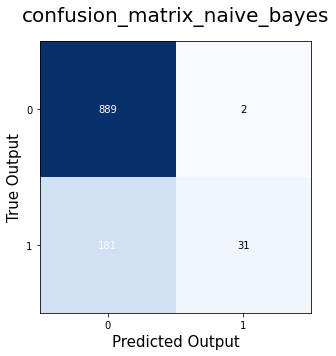

In [ ]:
print("Classification Report Test Data for Naive Bayes:\n\n",
      classification_report(ytest, ypred_nb_te)) ## classification report

conf_matrix(ytest, ypred_nb_te, "confusion_matrix_naive_bayes") ## confusion matrix

## 10. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

## creating object
clf_lr = LogisticRegression()
## getting parameters
param_ = {'C': [10 ** x for x in range(-3, 3)]}

## grid search cv to get the optimal output
clf = GridSearchCV(clf_lr, 
                   param_, 
                   cv=7, 
                   scoring='f1_micro',
                   return_train_score=True, 
                   verbose=True, 
                   n_jobs=-1). fit(x_train, ytrain)


print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

Fitting 7 folds for each of 6 candidates, totalling 42 fits
Best cross-validation score: 0.85
Best parameters:  {'C': 10}


In [ ]:
clf_lr = LogisticRegression(C = clf.best_params_['C']).fit(x_train, ytrain)  ## predicting with best parameters
ypred_lr_tr = clf_lr.predict(x_train); ypred_lr_te = clf_lr.predict(x_test) ## output prediction

train_acc_lr, test_acc_lr, test_fscore_lr, test_precision_lr, test_recall_lr = output_scores(ytrain, ypred_lr_tr, 
                                                                                             ytest, ypred_lr_te)

print("train and test accuracy are {:.4f} and {:.4f} respectively.".format(train_acc_lr, test_acc_lr))

print("test fscore, precision and recall are {:.4f}, {:.4f}, and {:.4f}.".format(test_fscore_lr, test_precision_lr, 
                                                                                 test_recall_lr))

train and test accuracy are 0.9948 and 0.8649 respectively.
test fscore, precision and recall are 0.5706, 0.7333, and 0.4670.


Classification Report Test Data for Logistic Regression :

               precision    recall  f1-score   support

           0       0.88      0.96      0.92       891
           1       0.73      0.47      0.57       212

    accuracy                           0.86      1103
   macro avg       0.81      0.71      0.75      1103
weighted avg       0.85      0.86      0.85      1103



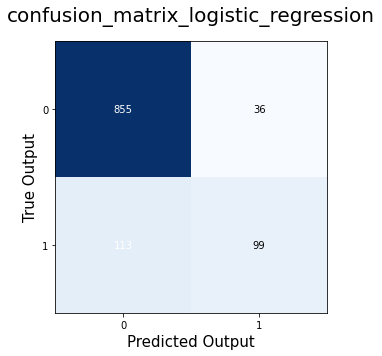

In [ ]:
print("Classification Report Test Data for Logistic Regression :\n\n",
      classification_report(ytest, ypred_lr_te)) ## classification report

conf_matrix(ytest, ypred_lr_te, "confusion_matrix_logistic_regression") ## confusion matrix

## 11. LSTM 

### 11.1 creating an embedding from given data

In [ ]:
#creating text corpus
sentence = ""
for i in df_m4["preprocessed_tweet"].values:
    sentence += str(i)
    sentence += " . "

f = open("text_corpus.txt", "w")
f.write(sentence) 
f.close()

In [ ]:
%%time
embedding_model = fasttext.train_unsupervised("text_corpus.txt", minn=3, maxn=6, wordNgrams=3, lr=0.1, dim=100)
embedding_model.save_model("embedding_model.bin")

CPU times: user 5.5 s, sys: 992 ms, total: 6.49 s
Wall time: 8.22 s


### 11.2 tokenization and padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(xtrain)
encoded_docs_train = tokenizer.texts_to_sequences(xtrain)
encoded_docs_test = tokenizer.texts_to_sequences(xtest)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlength = 25 #maximum length of a sentence to be padded
Xtrain = pad_sequences(encoded_docs_train, maxlen = maxlength, padding='post')
Xtest = pad_sequences(encoded_docs_test, maxlen = maxlength, padding='post')

In [ ]:
Xtrain

array([[ 533, 1329, 1330, ...,    0,    0,    0],
       [  75,    1,  743, ...,    0,    0,    0],
       [ 169, 2117,  461, ...,    0,    0,    0],
       ...,
       [7139, 7140, 1745, ...,    0,    0,    0],
       [7141, 7142,  530, ...,  533,  713,  713],
       [7147,  147,   38, ...,    0,    0,    0]], dtype=int32)

### 11. 3 creating embedding

In [ ]:
word_index = tokenizer.word_index #getting word index
vocab_size = len(word_index) + 1 #getting vocab size
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in word_index.items(): #creating embedding matrix
    dat = embedding_model.get_word_vector(word)
    if dat is not None:
        embedding_matrix[i] = dat
print('The shape of emdedding matrix is: ',embedding_matrix.shape)

The shape of emdedding matrix is:  (7149, 100)


### 11.4 one hot encoding of output data

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(ytrain, 2)
y_test = to_categorical(ytest, 2)

### 11.5 LSTM Model

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
inputs = Input(shape=(maxlength,), dtype='int32', name='Input_Text')
Embedding_Layer = Embedding(vocab_size, 100, weights = [embedding_matrix], input_length = maxlength, trainable=False)(inputs)
sp_drop = SpatialDropout1D(0.2)(Embedding_Layer)
lstmLayer =  tf.keras.layers.LSTM(128, kernel_initializer='glorot_normal', return_sequences=True,
                                   dropout=0.4, recurrent_dropout=0.4)(sp_drop)
flat = Flatten()(lstmLayer)
dropout = Dropout(0.2)(flat)
dense = Dense(64, activation='relu')(dropout)
output = Dense(2, activation='sigmoid')(dense)
lstm_model = Model(inputs,output)

In [ ]:
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Text (InputLayer)     [(None, 25)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 25, 100)           714900    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 25, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 25, 128)           117248    
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dropout_1 (Dropout)         (None, 3200)              0         
                                                           

In [ ]:
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"]) #compile the model
lstm_model.fit(Xtrain, y_train, batch_size=64, verbose=1, epochs=30, validation_data=(Xtest,y_test), shuffle=True,
          callbacks = [earlyStopping]) #fitting the model 

Epoch 1/30
69/69 [==============================] - 43s 100ms/step - loss: 0.4572 - accuracy: 0.8169 - val_loss: 0.4355 - val_accuracy: 0.8232
Epoch 2/30
69/69 [==============================] - 7s 98ms/step - loss: 0.4303 - accuracy: 0.8246 - val_loss: 0.4139 - val_accuracy: 0.8277
Epoch 3/30
69/69 [==============================] - 7s 95ms/step - loss: 0.4278 - accuracy: 0.8215 - val_loss: 0.4144 - val_accuracy: 0.8305
Epoch 4/30
69/69 [==============================] - 7s 97ms/step - loss: 0.4198 - accuracy: 0.8289 - val_loss: 0.4057 - val_accuracy: 0.8286
Epoch 5/30
69/69 [==============================] - 7s 97ms/step - loss: 0.4174 - accuracy: 0.8278 - val_loss: 0.4119 - val_accuracy: 0.8296
Epoch 6/30
69/69 [==============================] - 7s 96ms/step - loss: 0.4179 - accuracy: 0.8271 - val_loss: 0.4087 - val_accuracy: 0.8241
Epoch 7/30
69/69 [==============================] - 7s 99ms/step - loss: 0.4136 - accuracy: 0.8276 - val_loss: 0.4068 - val_accuracy: 0.8286


### 11.6 Prediction

In [ ]:
## using predict attribute to get the likelihood/probabilities
ytrain_pred_lstm = lstm_model.predict(Xtrain, verbose=1)
ytest_pred_lstm = lstm_model.predict(Xtest, verbose=1)

## getting the predicted class from the likelihoods
ytrain_predicted_lstm = [max(enumerate(val), key=operator.itemgetter(1))[0] for val in ytrain_pred_lstm]
ytest_predicted_lstm = [max(enumerate(val), key=operator.itemgetter(1))[0] for val in ytest_pred_lstm]

35/35 [==============================] - 0s 7ms/step


In [ ]:
train_acc_lstm, test_acc_lstm, test_fscore_lstm, test_precision_lstm, test_recall_lstm = output_scores(ytrain, ytrain_predicted_lstm, 
                                                                                                       ytest, ytest_predicted_lstm)

print("train and test accuracy are {:.4f} and {:.4f} respectively.".format(train_acc_lstm, test_acc_lstm))

print("test fscore, precision and recall are {:.4f}, {:.4f}, and {:.4f}.".format(test_fscore_lstm, test_precision_lstm, test_recall_lstm))

train and test accuracy are 0.8308 and 0.8286 respectively.
test fscore, precision and recall are 0.2158, 0.8966, and 0.1226.


Classification Report Test Data for lstm model:

               precision    recall  f1-score   support

           0       0.83      1.00      0.90       891
           1       0.90      0.12      0.22       212

    accuracy                           0.83      1103
   macro avg       0.86      0.56      0.56      1103
weighted avg       0.84      0.83      0.77      1103



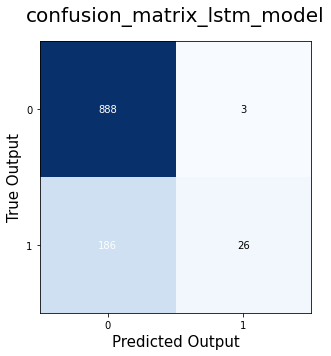

In [ ]:
print("Classification Report Test Data for lstm model:\n\n",
      classification_report(ytest, ytest_predicted_lstm)) ## classification report

conf_matrix(ytest, ytest_predicted_lstm, "confusion_matrix_lstm_model") ## confusion matrix

## 12. Attention Model

In [ ]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, att_units, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        #number of attention units to be provided
        self.att_units = att_units
        super(Attention, self).__init__(**kwargs)
        
        # Intialize variables needed for Concat score function here
        self.W1=tf.keras.layers.Dense(att_units)
        self.W2=tf.keras.layers.Dense(att_units)
        self.V=tf.keras.layers.Dense(1)

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({"att_units": self.att_units})
        return config

    def call(self,lstm_output, hidden_state):
        
        """
        hidden state shape == (batch_size, hidden size)
        lstm output shape == (batch_size, max_length, hidden size)
        """
        
        #state_with_time_axis shape == (batch_size, 1, hidden size)
        #we are doing this to broadcast addition along the time axis to calculate the score
        state_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        #score shape == (batch_size, max_length, 1)
        #we get 1 at the last axis because we are applying score to self.V
        #the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(state_with_time_axis) + self.W2(lstm_output)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights=tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights*lstm_output
        context_vector = tf.reduce_sum(context_vector, axis=1)  

        return context_vector, attention_weights

In [ ]:
inputs = Input(shape=(maxlength,), dtype='int32', name='Input_Text')
Embedding_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlength, trainable=False)(inputs)
lstm_output, fw_state_h, fw_state_c, bw_state_h, bw_state_c = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(Embedding_Layer)
state_h = Concatenate()([fw_state_h, bw_state_h])
context_vector, attention_weights = Attention(10)(lstm_output, state_h)
dense = Dense(128, activation='relu', name= "Dense_Layer")(context_vector)
output = Dense(2, activation='sigmoid', name= "Output_Layer")(dense)
model_attention = Model(inputs,output)

In [ ]:
model_attention.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"]) #compile the model
model_attention.fit(Xtrain, y_train, batch_size=64, verbose=1, epochs=30, validation_data=(Xtest,y_test), shuffle=True,
          callbacks = [earlyStopping]) #fitting the model 

Epoch 1/30
69/69 [==============================] - 6s 23ms/step - loss: 0.4810 - accuracy: 0.8158 - val_loss: 0.4269 - val_accuracy: 0.8141
Epoch 2/30
69/69 [==============================] - 1s 8ms/step - loss: 0.4281 - accuracy: 0.8221 - val_loss: 0.4216 - val_accuracy: 0.8178
Epoch 3/30
69/69 [==============================] - 1s 8ms/step - loss: 0.4213 - accuracy: 0.8258 - val_loss: 0.4138 - val_accuracy: 0.8241
Epoch 4/30
69/69 [==============================] - 1s 10ms/step - loss: 0.4182 - accuracy: 0.8287 - val_loss: 0.4132 - val_accuracy: 0.8250
Epoch 5/30
69/69 [==============================] - 1s 8ms/step - loss: 0.4178 - accuracy: 0.8296 - val_loss: 0.4136 - val_accuracy: 0.8314
Epoch 6/30
69/69 [==============================] - 1s 8ms/step - loss: 0.4112 - accuracy: 0.8303 - val_loss: 0.4101 - val_accuracy: 0.8259
Epoch 7/30
69/69 [==============================] - 1s 8ms/step - loss: 0.4093 - accuracy: 0.8296 - val_loss: 0.4144 - val_accuracy: 0.8259
Epoch 8/30
69/69 [

### 12.1 Prediction

In [ ]:
## using predict attribute to get the likelihood/probabilities
ytrain_pred_attn = model_attention.predict(Xtrain, verbose=1)
ytest_pred_attn = model_attention.predict(Xtest, verbose=1)

## getting the predicted class from the likelihoods
ytrain_predicted_attn = [max(enumerate(val), key=operator.itemgetter(1))[0] for val in ytrain_pred_attn]
ytest_predicted_attn = [max(enumerate(val), key=operator.itemgetter(1))[0] for val in ytest_pred_attn]

35/35 [==============================] - 0s 4ms/step


In [ ]:
train_acc_attn, test_acc_attn, test_fscore_attn, test_precision_attn, test_recall_attn = output_scores(ytrain, ytrain_predicted_attn, 
                                                                                                       ytest, ytest_predicted_attn)

print("train and test accuracy are {:.4f} and {:.4f} respectively.".format(train_acc_attn, test_acc_attn))

print("test fscore, precision and recall are {:.4f}, {:.4f}, and {:.4f}.".format(test_fscore_attn, test_precision_attn, test_recall_attn))

train and test accuracy are 0.8362 and 0.8305 respectively.
test fscore, precision and recall are 0.2724, 0.7778, and 0.1651.


Classification Report Test Data for attention model:

               precision    recall  f1-score   support

           0       0.83      0.99      0.90       891
           1       0.78      0.17      0.27       212

    accuracy                           0.83      1103
   macro avg       0.81      0.58      0.59      1103
weighted avg       0.82      0.83      0.78      1103



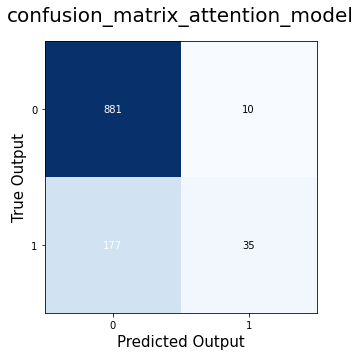

In [ ]:
print("Classification Report Test Data for attention model:\n\n",
      classification_report(ytest, ytest_predicted_attn)) ## classification report

conf_matrix(ytest, ytest_predicted_attn, "confusion_matrix_attention_model") ## confusion matrix

## 13. Model Comparison

In [ ]:
## getting list of scores
model_name = ['Naive Bayes', 'Logistic Regression', 'LSTM', 'Attention']
train_accuracy_scores = [train_acc_nb, train_acc_lr, train_acc_lstm, train_acc_attn]
test_accuracy_scores = [test_acc_nb, test_acc_lr, test_acc_lstm, test_acc_attn]
f1_scores = [test_fscore_nb, test_fscore_lr, test_fscore_lstm, test_fscore_attn]

### 13.1 accuracy scores

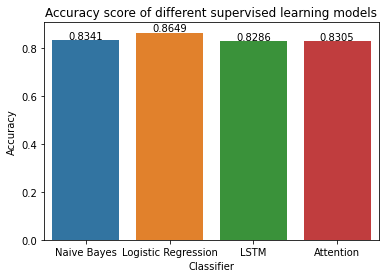

In [ ]:
axis = sns.barplot(x = model_name, y = test_accuracy_scores)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
plt.title('Accuracy score of different supervised learning models')
plt.show()

### 13.2 f1score

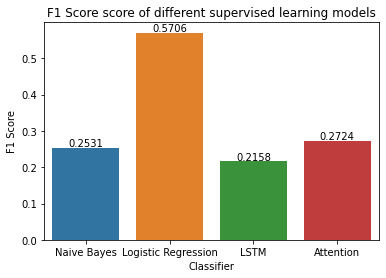

In [ ]:
axis = sns.barplot(x = model_name, y = f1_scores)
axis.set(xlabel='Classifier', ylabel='F1 Score')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
plt.title('F1 Score score of different supervised learning models')
plt.show()